# Case 3 - Water Table Estimation & Well Optimization
Welcome to the demonstration notebook where we'll spatially estimate the groundwater table and then go over an example for well optimization to select a subset of wells to capture the spatiotemporal variability of groundwater table using the **pylenm** package!<br>
Let’s get started!

## Notebook roadmap

This demo is organized into short sections so you can follow it top-to-bottom.

- Load and pre-process data
- Build the spatial model
- Well optimization

> Tip: You can run the notebook cell-by-cell, or use **Run All** once the dependencies are installed.


## Setup
Make sure to install pylenm from https://pypi.org/project/pylenm/ by running `pip install pylenm_` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

In [2]:
# pip install pyproj

In [3]:
# pip install rasterio

In [4]:
# pip install elevation

In [5]:
# pip install richdem

In [2]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from math import sqrt
from sklearn.metrics import r2_score

# pylenm
import pylenm
print("pylenm version: ", pylenm.__version__)
from pylenm import PylenmDataFactory

# GIS data layers
from pyproj import Transformer, CRS
import rasterio
import elevation
import richdem as rd

plt.rcParams["font.family"] = "Times New Roman"

## Load and pre-process data

### Load GIS data layers

In [3]:
# Load GIS elevation data
# UNCOMMENT THE 2 LINES BELOW IF YOU DO NOT HAVE THE DEM FILE ALREADY
# dem_path = os.path.join(os.getcwd(), 'FArea-30m-DEM_cropped.tif')
# elevation.clip(bounds=(-81.6855, 33.2657, -81.6734, 33.2785), output=dem_path)

# IF YOU DO HAVE THE DEM FILE ALREADY
dem_path = "data/FArea-30m-DEM_cropped.tif"

farea_dem = rd.LoadGDAL(dem_path)
farea_ras = rasterio.open(dem_path)

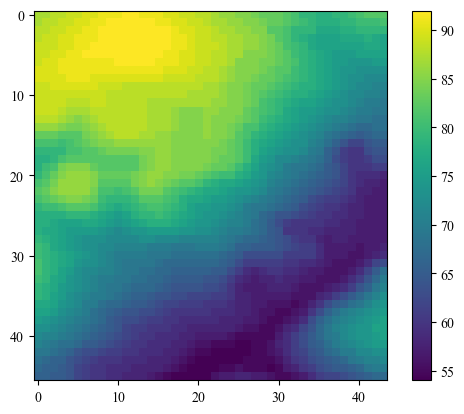

In [4]:
plt.imshow(farea_dem, interpolation='none')
plt.colorbar()
plt.show()

In [5]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)

x_loc = np.zeros([farea_ras.height, farea_ras.width])
y_loc = np.zeros([farea_ras.height, farea_ras.width])
for i in range(farea_ras.height):
  for j in range(farea_ras.width):
    lon = farea_ras.xy(i,j)[0]
    lat = farea_ras.xy(i,j)[1]
    utm_x, utm_y =proj.transform(lat,lon) # Latitude/Longitude to UTM
    x_loc[i,j] = utm_x
    y_loc[i,j] = utm_y

In [6]:
slope = rd.TerrainAttribute(farea_dem, attrib='slope_riserun')
accum = rd.FlowAccumulation(farea_dem, method='D8')
twi   = np.log(accum/slope)

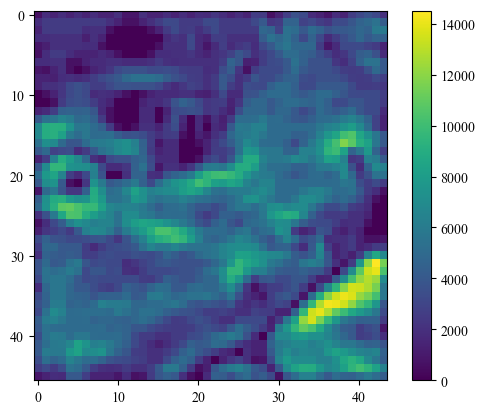

In [7]:
plt.imshow(slope, interpolation='none')
plt.colorbar()
plt.show()

### Load well time series data + preprocess

In [8]:
# Load and process well time-series data
url_1 = 'data/farea_data_thru_2015q3_reduced_demo.csv'
url_2 = 'data/farea_station_construction_data.csv'
concentration_data = pd.read_csv(url_1)
construction_data = pd.read_csv(url_2)

pylenm_df = PylenmDataFactory(concentration_data)
pylenm_df.simplify_data(inplace=True)
pylenm_df.setConstructionData(construction_data)

Successfully imported the data!

Successfully imported the construction data!



Data summary for water table

In [9]:
WT_details = pylenm_df.get_analyte_details('DEPTH_TO_WATER')
WT_details

,Start Date,End Date,Date Range (days),Unique samples
Well Name,,,,
FSB-094D,1990-01-01,1990-10-08,280,4
FSB-095D,1990-01-01,1990-10-08,280,4
FSB-077,1990-01-01,2006-10-16,6132,122
FSB-111C,1990-01-01,2006-10-17,6133,115
FSB-105C,1990-01-01,2006-10-19,6135,127
...,...,...,...,...
FSB-146D,2015-04-29,2015-09-09,133,9
FSB-145D,2015-04-30,2015-09-09,132,9
FSB-143D,2015-05-04,2015-09-09,128,9


Select wells that have enough and recent samples

In [10]:
n_samples = WT_details['Unique samples']
end_date = WT_details['End Date']
start_date = WT_details['Start Date']
well_names  = WT_details.index
well_enough = well_names[n_samples>20]

well_recent = well_names[end_date> datetime.strptime('2015-01-01', '%Y-%m-%d').date()]
well_old    = well_names[start_date< datetime.strptime('2006-01-01', '%Y-%m-%d').date()]

Temporal interpolation of the time series at equal frequency

In [11]:
wt_interp = pylenm_df.interpolate_wells_by_analyte('DEPTH_TO_WATER', frequency='1M', rm_outliers=True, z_threshold=3)

Select the upper aquifer wells and the wells that have enough samples

52 wells


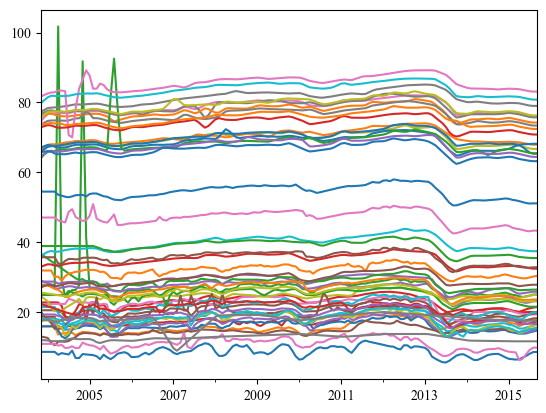

In [12]:
active = list(np.unique(pylenm_df.filter_by_column(pylenm_df.get_Construction_Data(), col='WELL_USE', equals=['ACTIVE']).index))
upper_wells = list(np.unique(pylenm_df.filter_by_column(pylenm_df.get_Construction_Data(), col='AQUIFER', equals=['UAZ_UTRAU']).index))
well_only_D = list(set(upper_wells) & set(wt_interp.columns)& set(well_enough)& set(well_recent)& set(well_old) & set(active))
wt_interp = wt_interp[well_only_D]
wt_interp.plot(legend=False)
print(wt_interp.shape[1], "wells")

Let's remove the 'bad' time series wells

46 wells


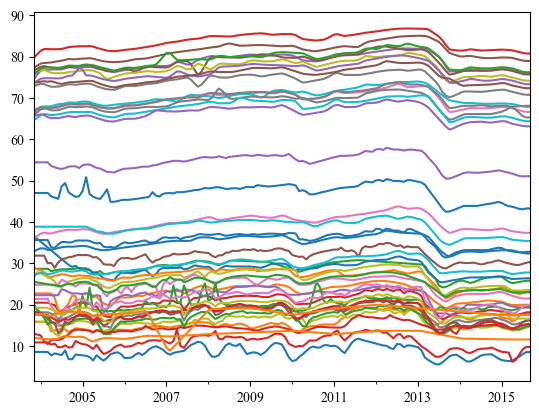

In [13]:
bad_ones = ['FSB-108D', 'FSB-131D', 'FSB-090D', 'FOB-013D', 'FBI-014D', 'FBI-017D']
wt_interp = wt_interp.drop(columns=bad_ones)
wt_interp.plot(legend=False)
print(wt_interp.shape[1], "wells")

In [14]:
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

# Convert to meters
wt_interp = wt_interp * 0.3048

<Axes: >

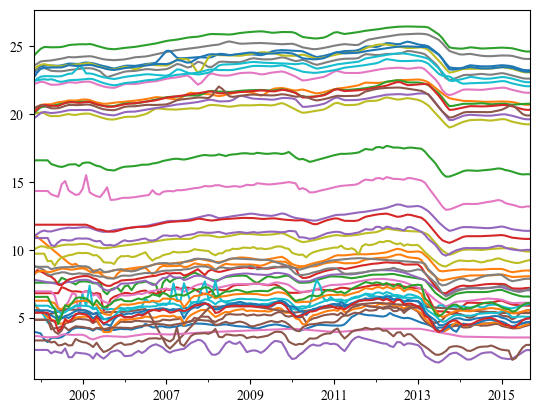

In [15]:
wt_interp.plot(legend=False)

### Prepare well location (coordinates) data

In [16]:
well_info = pylenm_df.get_Construction_Data()

Match the well indecies between the time series and locations

In [17]:
shared_wells = list(set(well_info.index) & set(wt_interp.columns))
wt_interp = wt_interp[shared_wells]
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

well_info = well_info.T[shared_wells]
# Reorder columns to be in alphabetical order
well_info = well_info.reindex(sorted(well_info.columns), axis=1)
well_info = well_info.T

In [18]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)
UTM_x, UTM_y = proj.transform(well_info.LATITUDE,well_info.LONGITUDE)

Take out the ground-surface elevation, and compute the water table elevation

In [19]:
elev = well_info.REFERENCE_ELEVATION
elev.index = well_info.index
elev = elev.T
elev = elev * 0.3048 # convert to meters

# Now this is the water table elevation (GROUND_ELEVATION - DEPTH_TO_WATER)
wt_interp = elev.values - wt_interp

# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

In [20]:
wt_interp = wt_interp.apply(pd.to_numeric, errors='coerce')
# wt_interp = np.log2(wt_interp)
wt_interp = np.log10(wt_interp)

In [21]:
# GETS APPROXIMATE WT VALUE IN THE XX GRID
def get_approx_predictions(X, y_map, XX):
    X_approx, y_approx = [],[]
    for i in range(X.shape[0]):
        x1, y1 = X.iloc[i].Easting, X.iloc[i].Northing # ACTUAL POINT
        abs_east = np.abs(XX.Easting-x1)
        abs_north= np.abs(XX.Northing-y1)
        c = np.maximum(abs_north,abs_east)
        index = np.argmin(c)
        XX.iloc[index].Easting, XX.iloc[index].Northing
        X_approx.append([XX.iloc[index].Easting, XX.iloc[index].Northing, XX.iloc[index].Elevation])
        y_approx.append(y_map[index])
    X_approx = pd.DataFrame(X_approx, columns=['Easting', 'Northing', 'Elevation'])
    return X_approx, y_approx

In [22]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

XX = np.vstack([x_loc.flatten(), y_loc.flatten(), farea_dem.flatten(), slope.flatten(), accum.flatten()]).T
XX = pd.DataFrame(XX, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])


X_approx, Slope_X = get_approx_predictions(X, slope.flatten(), XX)
X_approx, Acc_X = get_approx_predictions(X, accum.flatten(), XX)

X = np.vstack((UTM_x,UTM_y, elev.values, Slope_X, Acc_X)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

In [23]:
print(X.shape)
X.head()

(46, 5)


,Easting,Northing,Elevation,Slope,Acc
0,436915.185626,3681526.011324,64.864488,3710.795166,1.0
1,436691.311919,3681466.821435,70.673976,5400.0,2.0
2,436815.34352,3681532.531246,69.872352,6644.17041,4.0
3,436842.110445,3681572.787131,69.238368,5130.789551,3.0
4,436664.132457,3681447.159625,69.7992,4970.412598,18.0


In [24]:
print(XX.shape)
XX.head()

(2024, 5)


,Easting,Northing,Elevation,Slope,Acc
0,436159.683552,3.682384e+06,87.0,636.396118,1.0
1,436185.551274,3.682384e+06,87.0,1909.188354,7.0
2,436211.418995,3.682384e+06,88.0,1423.024902,1.0
3,436237.286716,3.682384e+06,88.0,1909.188354,6.0
4,436263.154436,3.682383e+06,89.0,1423.024902,1.0


In [25]:
year = 2015
y = np.array(wt_interp.loc[wt_interp.index[pd.Series(wt_interp.index).dt.year == year]].mean())
print(y)
well_names = list(wt_interp.columns)

[1.78084772 1.79667497 1.80034253 1.80106015 1.79754437 1.79296123
 1.79563884 1.81633646 1.80414424 1.7826687  1.8077243  1.81476059
 1.81347143 1.81119492 1.80912664 1.80620616 1.8060297  1.80538257
 1.80596917 1.80750673 1.80893034 1.79566047 1.81034381 1.79847031
 1.81569102 1.76549896 1.76618215 1.80134264 1.80734817 1.80137682
 1.79129522 1.80740523 1.80175646 1.80252038 1.79956168 1.77849724
 1.79692823 1.78373745 1.79528575 1.79685459 1.79469989 1.79668663
 1.79203813 1.79137609 1.77629382 1.79061915]


In [26]:
y_map, r_map, residuals, lr_trend = pylenm_df.interpolate_topo(X, y, XX, ft=['Elevation'], regression='linear', smooth=True)

## Build the spatial model


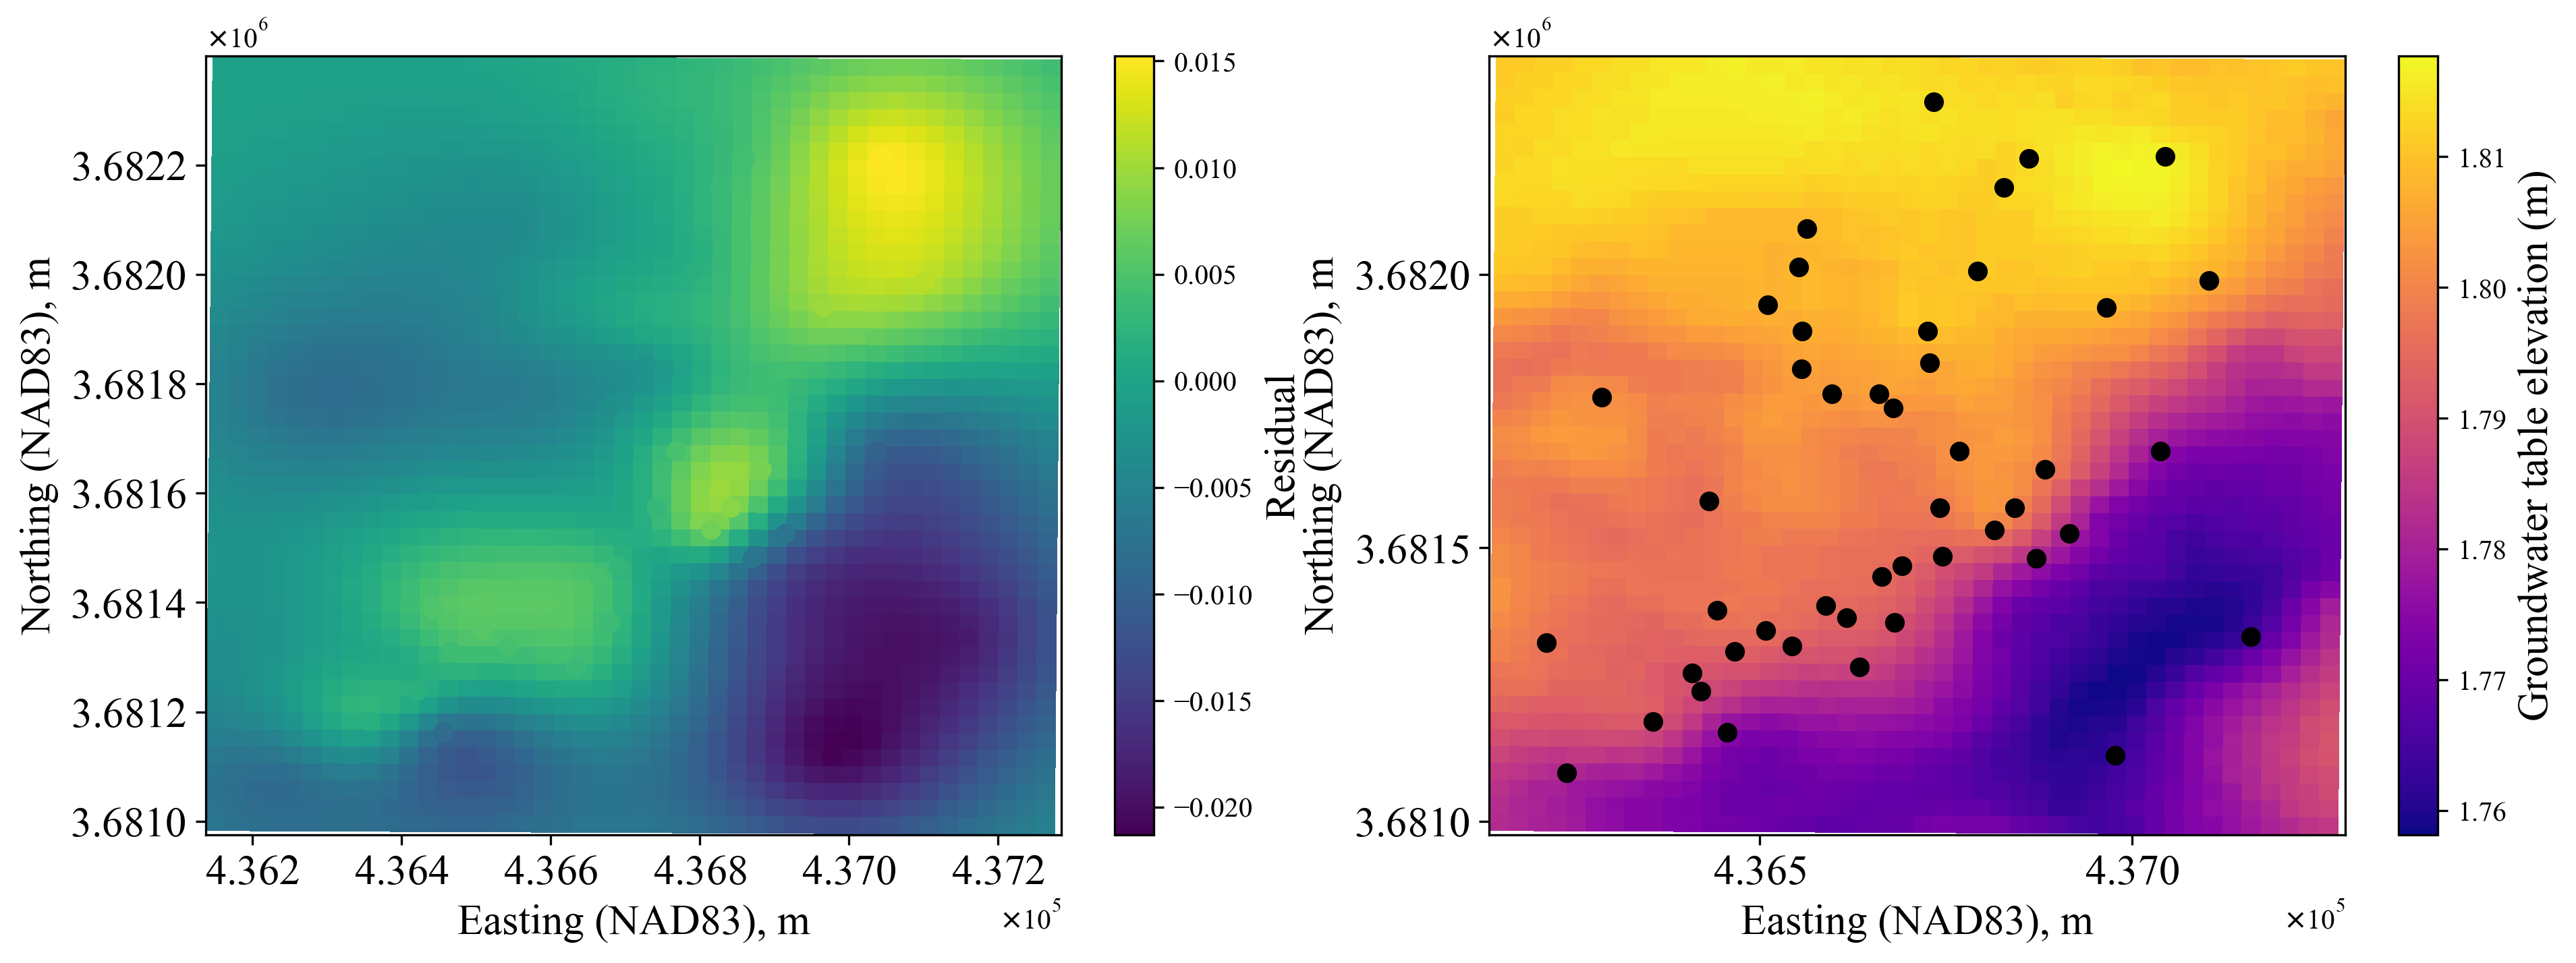

In [27]:
# Plot all result details
fontsize = 15

fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
xx = np.array(XX)
plt.locator_params(axis='both', nbins=4, tight=False)
titles = ["Kriging map colored by residuals from\n Regression trend line", str("Linear Regression + Kriging\n Water table Reference Field | {}".format("Averaged 2005"))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                r_map.reshape(x_loc.shape))
fig.colorbar(map_0, ax=ax[0]).set_label(label='Residual',size=fontsize)
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1]).set_label(label='Groundwater table elevation (m)',size=fontsize)
colors=[residuals, 'black']
for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1)
    # ax[i].set_xticks(fontsize=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    # ax[i].yticks(fontsize=fontsize)
    ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
    ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
    # ax[i].set_title(titles[i],y=1.04, fontweight='bold')
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
fig.show()

In [29]:
pd.set_option('max_colwidth', 100)

# TEST ALL - Regular Fitting Process
model_results = pd.DataFrame(columns=['model', 'features', 'mse', 'r2'])

# Save GP results 
gp, y_map_gp = pylenm_df.fit_gp(X=X[['Easting', 'Northing']], y=y, xx=XX[['Easting', 'Northing']])
X_approx, y_approx = get_approx_predictions(X, y_map_gp, XX)
model_results.loc[len(model_results.index)] = ["GP", np.nan, pylenm_df.mse(y, y_approx), r2_score(y, y_approx)]

feature_params = [['Elevation'],['Elevation', 'Slope'], ['Easting', 'Northing'], ['Easting', 'Northing', 'Elevation'], ['Easting', 'Northing', 'Elevation', 'Slope'], ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc']]

# Save Results for our approach  
for ft in feature_params:
    y_map_lr, r_map_lr, residuals_lr, lr_trend = pylenm_df.interpolate_topo(X, y, XX, ft=ft, regression='linear', smooth=True)
    y_map_rf, r_map_rf, residuals_rf, rf_trend = pylenm_df.interpolate_topo(X, y, XX, ft=ft, regression='rf', smooth=True)
    y_map_rid, r_map_rid, residual_rid, rid_trend = pylenm_df.interpolate_topo(X, y, XX, ft=ft, regression='ridge', smooth=True)
    y_map_las, r_map_las, residuals_las, las_trend = pylenm_df.interpolate_topo(X, y, XX, ft=ft, regression='lasso', smooth=True)

    y_maps = [y_map_lr, y_map_rf, y_map_rid, y_map_las]
    model_names = ["Linear", "Random Forest", "Ridge", "Lasso"]
    for y_map, model_name in zip(y_maps, model_names):
        X_approx, y_approx = get_approx_predictions(X, y_map, XX)
        model_results.loc[len(model_results.index)] = [model_name, ft, pylenm_df.mse(y, y_approx), r2_score(y, y_approx)]

In [30]:
model_results.sort_values(by='r2', ascending=False)

,model,features,mse,r2
10,Random Forest,"[Easting, Northing]",2.297101e-07,0.998336
20,Lasso,"[Easting, Northing, Elevation, Slope]",2.662790e-07,0.998071
19,Ridge,"[Easting, Northing, Elevation, Slope]",2.824821e-07,0.997954
16,Lasso,"[Easting, Northing, Elevation]",2.856415e-07,0.997931
11,Ridge,"[Easting, Northing]",2.860051e-07,0.997928
12,Lasso,"[Easting, Northing]",2.860077e-07,0.997928
9,Linear,"[Easting, Northing]",2.860084e-07,0.997928
15,Ridge,"[Easting, Northing, Elevation]",3.016235e-07,0.997815
17,Linear,"[Easting, Northing, Elevation, Slope]",3.029518e-07,0.997806
13,Linear,"[Easting, Northing, Elevation]",3.236347e-07,0.997656


### Model assessment - leave-one-out cross validation

In [32]:
# TEST ALL - Leave-One-Out Cross Validation Process
model_results_LOO = pd.DataFrame(columns=['model', 'features', 'mse', 'r2'])

# Save GP results
y_approx_loo_gp = []
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gp, y_map_gp = pylenm_df.fit_gp(X=X_train[['Easting', 'Northing']], y=y_train, xx=XX[['Easting', 'Northing']])
    X_approx_test_gp, y_approx_test_gp = get_approx_predictions(X_test, y_map_gp, XX)
    y_approx_loo_gp.append(y_approx_test_gp)
model_results_LOO.loc[len(model_results_LOO.index)] = ["GP", np.nan, pylenm_df.mse(y, y_approx_loo_gp), r2_score(y, y_approx_loo_gp)]

feature_params = [['Elevation'],['Elevation', 'Slope'], ['Easting', 'Northing'], ['Easting', 'Northing', 'Elevation'], ['Easting', 'Northing', 'Elevation', 'Slope'], ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc']]

# Save Results for our approach  
for ft in feature_params:
    y_approx_loo_lr, y_approx_loo_rf, y_approx_loo_rid, y_approx_loo_las = [], [], [], []
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_map_lr, r_map_lr, residuals_lr, lr_trend = pylenm_df.interpolate_topo(X_train, y_train, XX, ft=ft, regression='linear', smooth=True)
        y_map_rf, r_map_rf, residuals_rf, rf_trend = pylenm_df.interpolate_topo(X_train, y_train, XX, ft=ft, regression='rf', smooth=True)
        y_map_rid, r_map_rid, residual_rid, rid_trend = pylenm_df.interpolate_topo(X_train, y_train, XX, ft=ft, regression='ridge', smooth=True)
        y_map_las, r_map_las, residuals_las, las_trend = pylenm_df.interpolate_topo(X_train, y_train, XX, ft=ft, regression='lasso', smooth=True)

        X_approx_test_lr, y_approx_test_lr = get_approx_predictions(X_test, y_map_lr, XX)
        X_approx_test_rf, y_approx_test_rf = get_approx_predictions(X_test, y_map_rf, XX)
        X_approx_test_rid, y_approx_test_rid = get_approx_predictions(X_test, y_map_rid, XX)
        X_approx_test_las, y_approx_test_las = get_approx_predictions(X_test, y_map_las, XX)
        
        y_approx_loo_lr.append(y_approx_test_lr)
        y_approx_loo_rf.append(y_approx_test_rf)
        y_approx_loo_rid.append(y_approx_test_rid)
        y_approx_loo_las.append(y_approx_test_las)

    y_preds = [y_approx_loo_lr, y_approx_loo_rf, y_approx_loo_rid, y_approx_loo_las]
    model_names = ["Linear", "Random Forest", "Ridge", "Lasso"]
    for y_approx, model_name in zip(y_preds, model_names):
        model_results_LOO.loc[len(model_results_LOO.index)] = [model_name, ft, pylenm_df.mse(y, y_approx), r2_score(y, y_approx)]

In [33]:
model_results_LOO.sort_values(by='r2', ascending=False)

,model,features,mse,r2
14,Random Forest,"[Easting, Northing, Elevation]",0.000019,0.865348
22,Random Forest,"[Easting, Northing, Elevation, Slope, Acc]",0.000019,0.862884
18,Random Forest,"[Easting, Northing, Elevation, Slope]",0.000019,0.861804
9,Linear,"[Easting, Northing]",0.000022,0.840138
12,Lasso,"[Easting, Northing]",0.000022,0.840136
11,Ridge,"[Easting, Northing]",0.000022,0.840133
16,Lasso,"[Easting, Northing, Elevation]",0.000022,0.837617
4,Lasso,[Elevation],0.000023,0.835217
1,Linear,[Elevation],0.000023,0.832510
3,Ridge,[Elevation],0.000023,0.831915


In [34]:
y_map, r_map, residuals, trend = pylenm_df.interpolate_topo(X, y, XX, ft=['Easting', 'Northing', 'Elevation', 'Slope'], regression='lasso', smooth=True)

### Visualize results

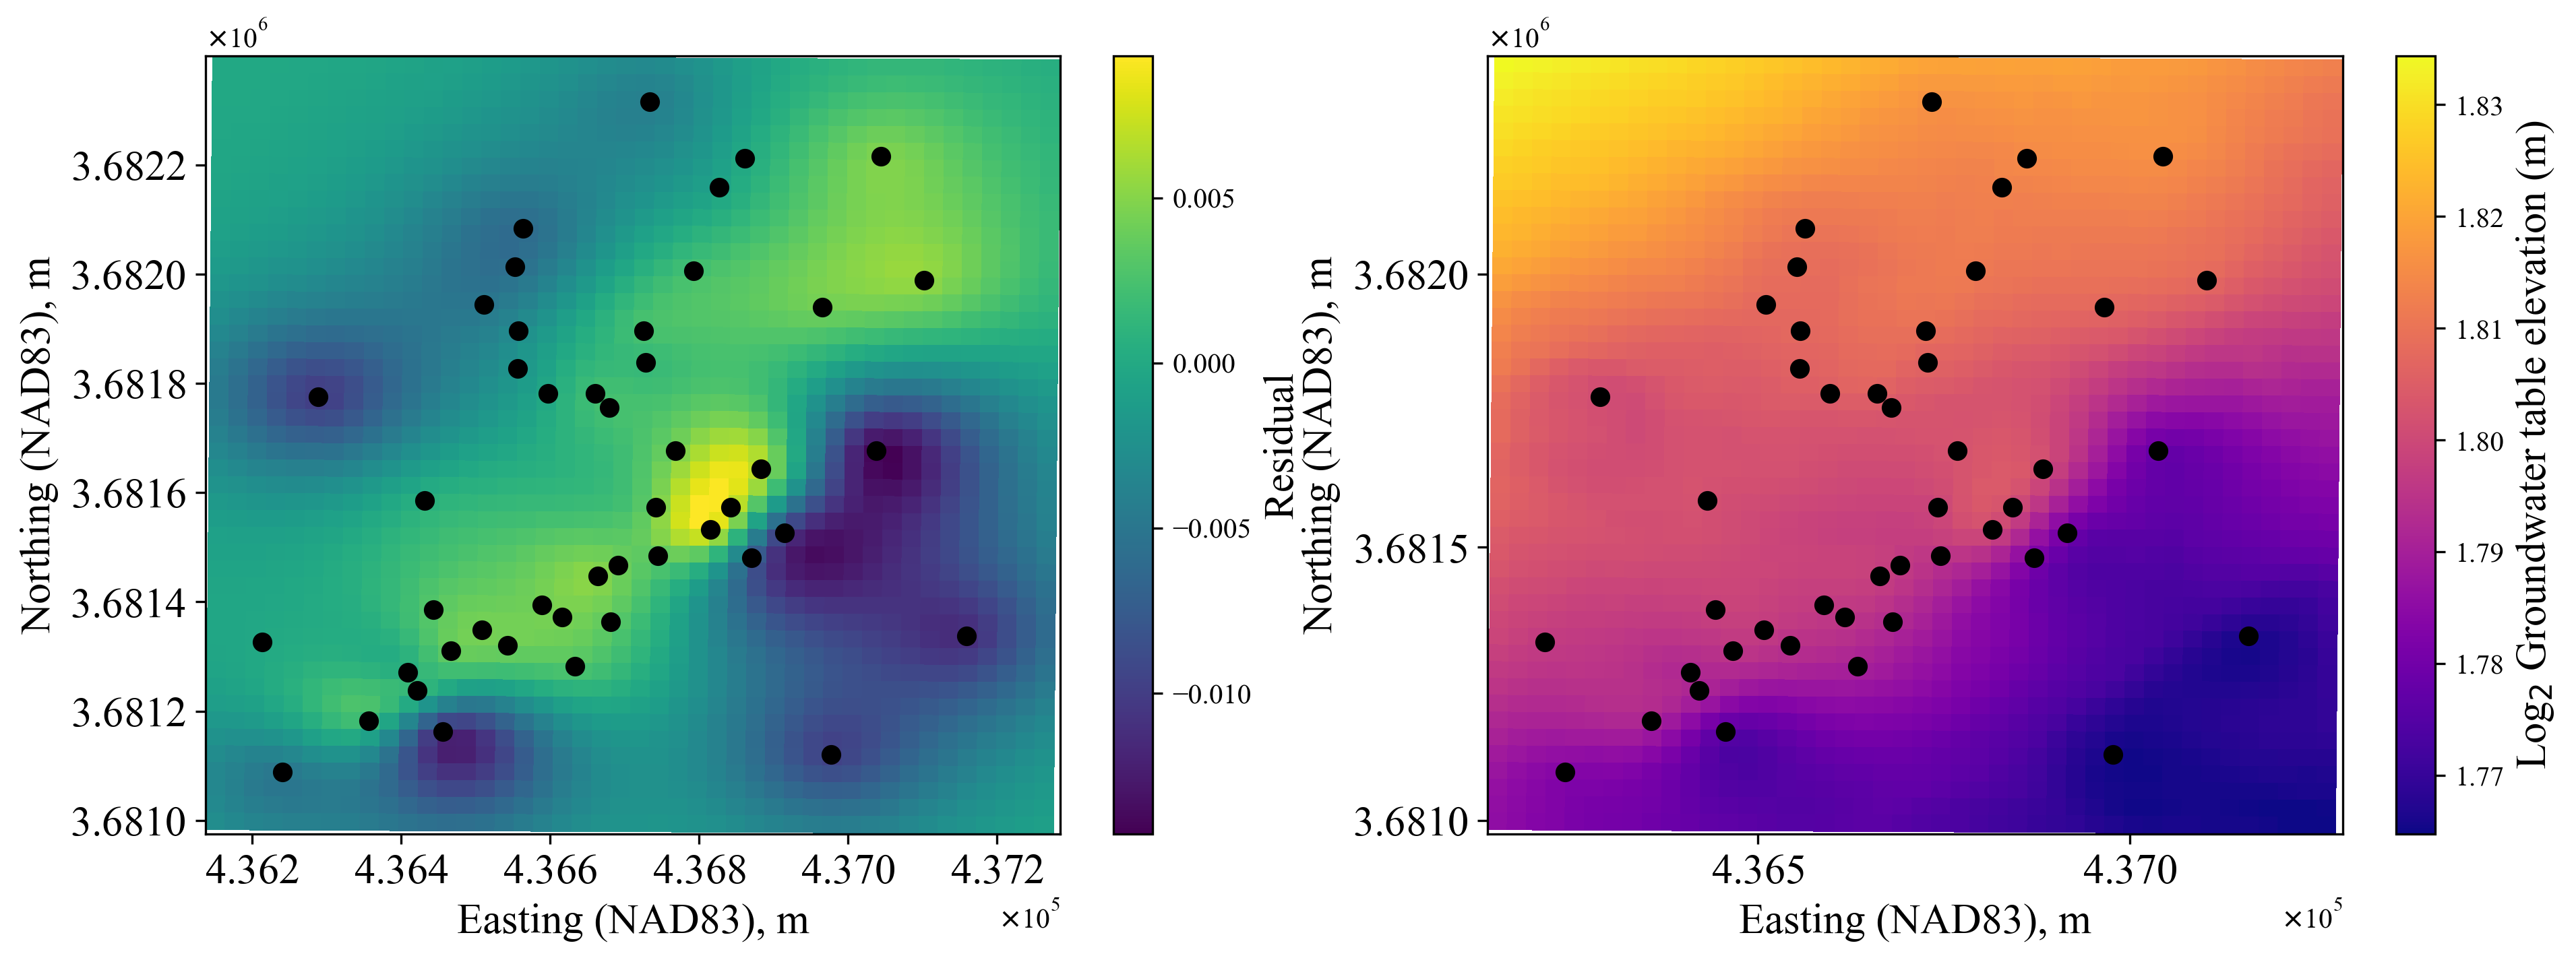

In [35]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
fontsize=15
xx = np.array(XX)

titles = ["Kriging map colored by residuals from\n Regression trend line", str("Linear Regression + Kriging\n Log{} Tritium Reference Field | {}".format('$_{2}$',"Averaged 2011",))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                r_map.reshape(x_loc.shape))
fig.colorbar(map_0, ax=ax[0]).set_label(label='Residual',size=fontsize)
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1]).set_label(label="Log{} Groundwater table elevation (m)".format('$_{2}$'), size=fontsize)
colors=['black', 'black']
for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1)
    plt.rc('font', size=fontsize)
    # ax[i].set_xticks(fontsize=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    # ax[i].yticks(fontsize=fontsize)
    ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
    ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
    # ax[i].set_title(titles[i],y=1.04, fontweight='bold')
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
plt.locator_params(axis='x', nbins=4, tight=False)
plt.locator_params(axis='y', nbins=4, tight=False)
fig.show()

In [36]:
X_approx, y_approx = get_approx_predictions(X, y_map, XX)

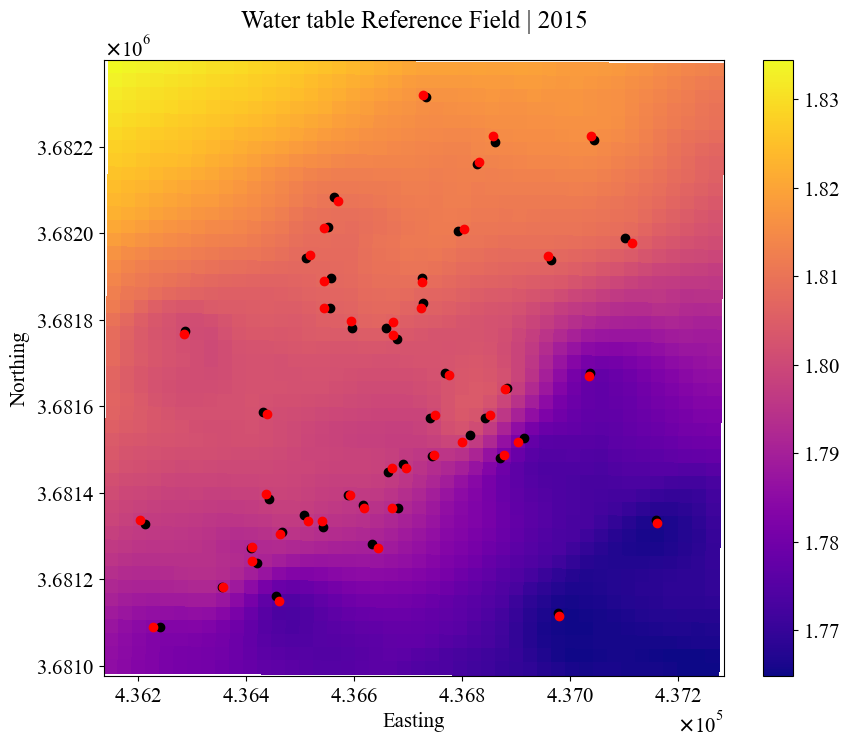

In [37]:
# Plot all result details
fig, ax = plt.subplots(1,1,figsize=(10,8))
xx = np.array(XX)
titles = [str("Water table Reference Field | {}".format(year))]
map_1 = ax.pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax)
ax.scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1) # Real point
ax.scatter(X_approx.iloc[:,0], X_approx.iloc[:,1], c='red', alpha=1, cmap='plasma') # Approximate point
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title(titles[0],y=1.04)
ax.ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
fig.show()

MSE LR:  2.6627898825696953e-07
R^2 LR:  0.9980712159172918
[0. 0. 0. 0. 0. 0.]


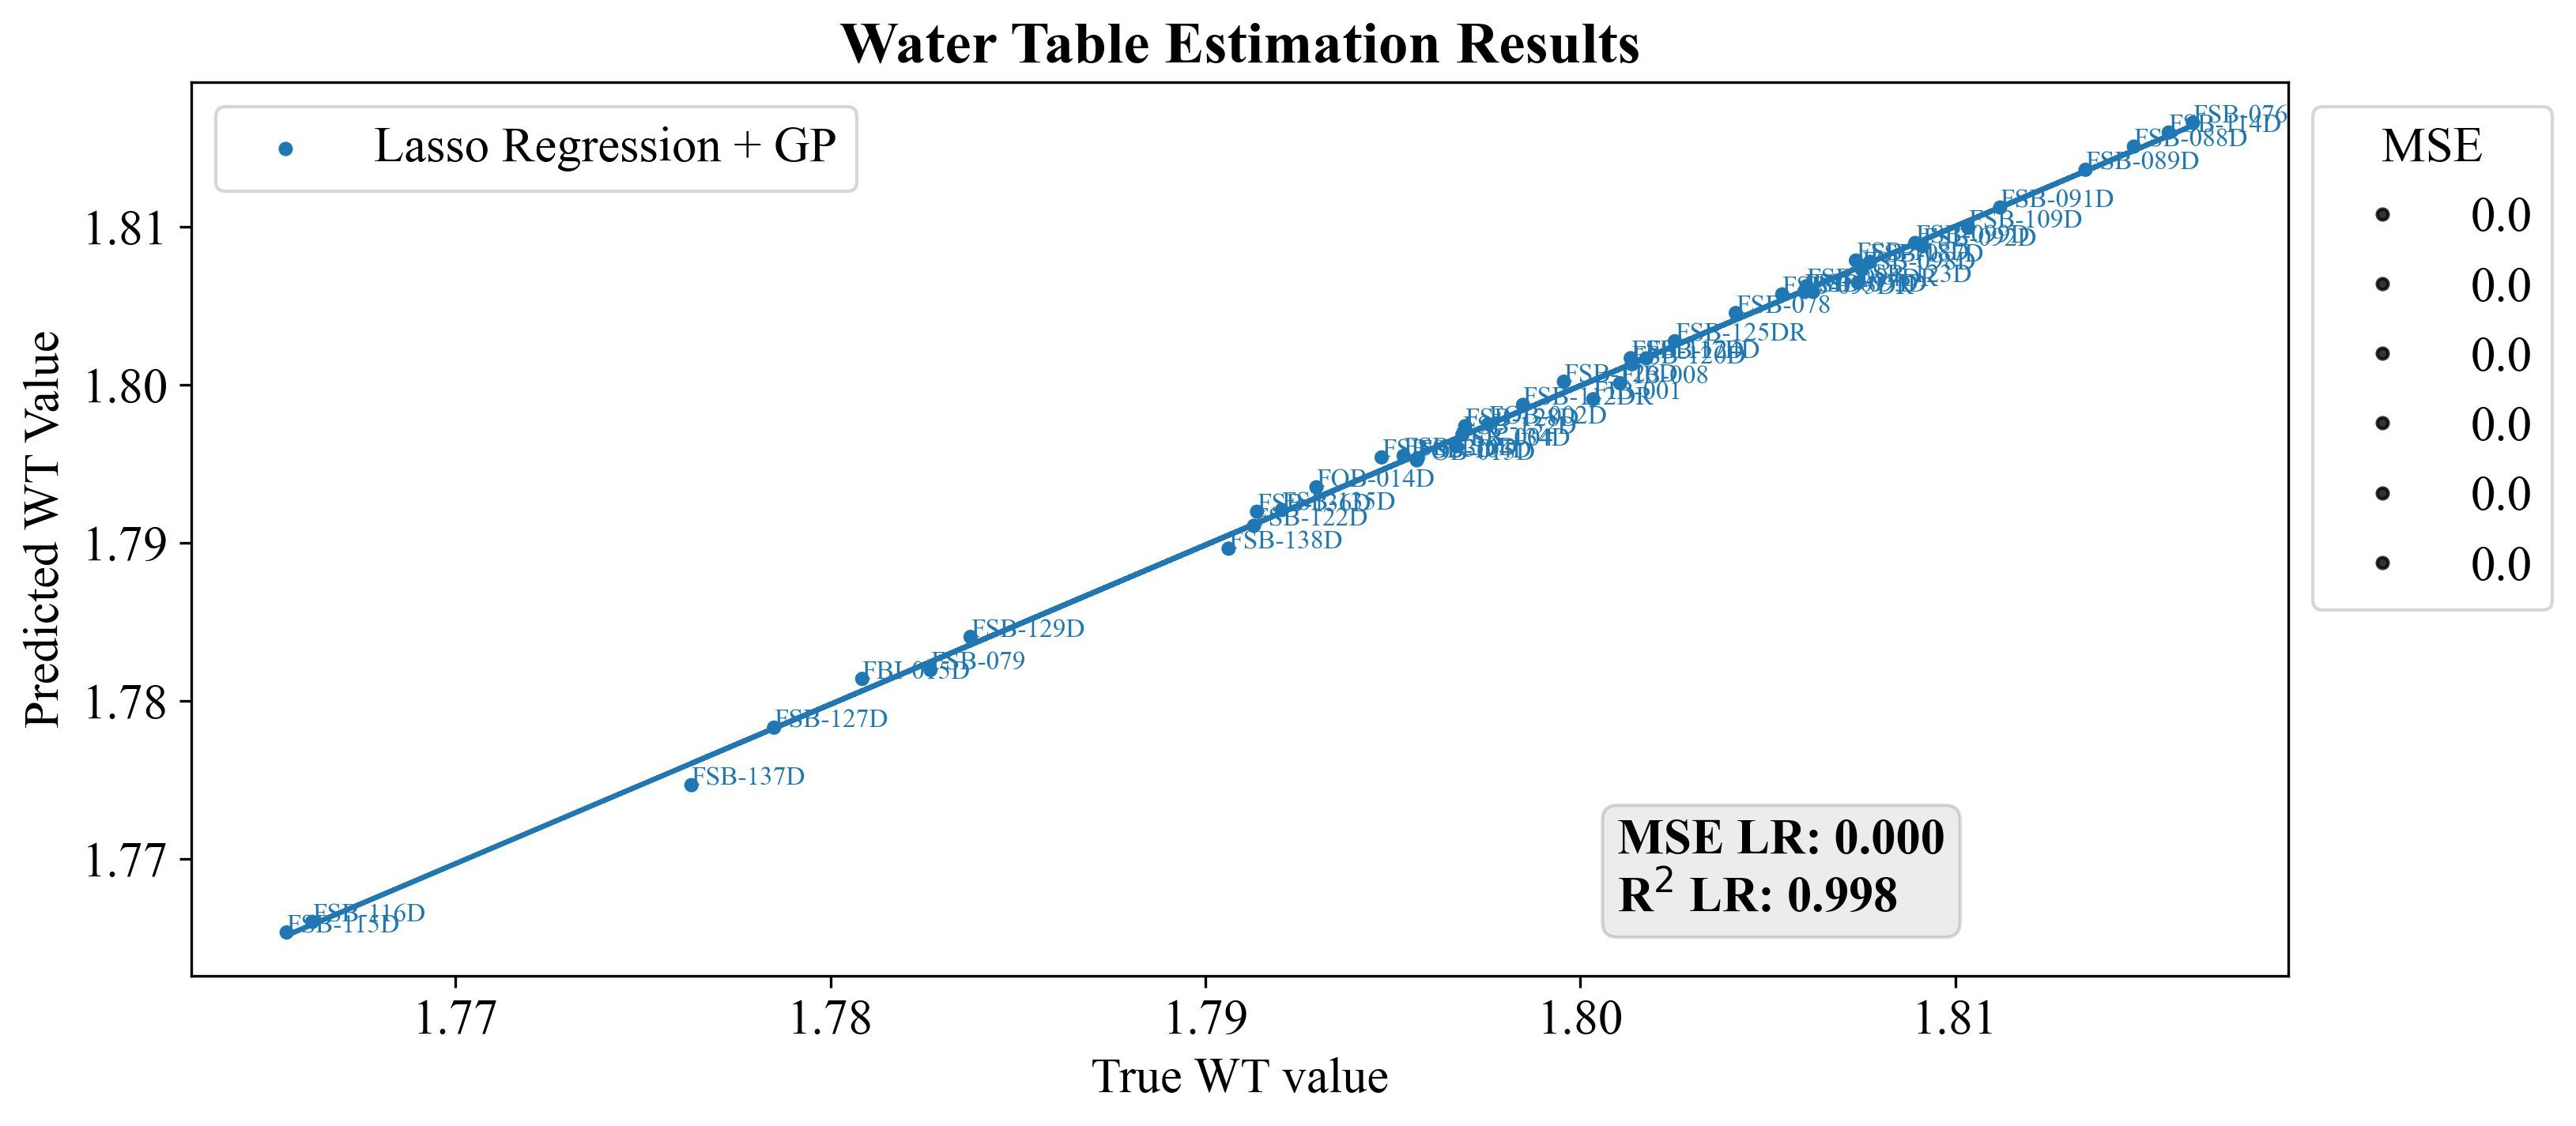

<Figure size 1280x960 with 0 Axes>

In [38]:
fig, ax = plt.subplots(figsize=(10,5),dpi=300)
plt.rcParams["legend.loc"] = 'upper left'
print("MSE LR: ",pylenm_df.mse(y, y_approx))

print("R^2 LR: ",r2_score(y, y_approx))
text = "MSE LR: {:.3f}".format(pylenm_df.mse(y, y_approx)) + "\n" + "R{} LR: {:.3f}".format('$^{2}$', r2_score(y, y_approx))
plt.figure( dpi=200)
ax.set_title('Water Table Estimation Results',fontweight='bold')
ax.set_xlabel('True WT value')
ax.set_ylabel('Predicted WT Value')

err_lr = []
for i in range(len(y)):
    err_lr.append(pylenm_df.mse([y[i]], [y_approx[i]]))
minmaxscaler=MinMaxScaler()
minmaxscaler.fit_transform(np.array(err_lr).reshape(-1,1)).flatten().tolist()

err_lr_s = [(x+5)**1.5 for x in err_lr]
scatter1 = ax.scatter(y, y_approx, label = "Lasso Regression + GP", s=err_lr_s)
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
fig.tight_layout()
fig.text(0.68, 0.06, text, transform=ax.transAxes, fontsize=15, fontweight='bold', verticalalignment='bottom', bbox=props) #1.025, 0.06

m_lr, b_lr = np.polyfit(y.astype("float64"), np.array(y_approx).flatten(), 1)

legend1 = ax.legend()
ax.add_artist(legend1)
# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter1.legend_elements(prop="sizes", alpha=0.8)
labels=np.round(np.linspace(min(np.array(err_lr).min(),np.array(err_lr).min()), max(np.array(err_lr).max(),np.array(err_lr).max()) ,6),3)
print(labels)
legend2 = ax.legend(handles, labels, title="MSE", bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
for i, txt in enumerate(well_names):
    ax.annotate(txt, (y[i], y_approx[i]), fontsize=8, color='#1f77b4')

ax.plot(y, m_lr*y + b_lr)

## Well optimization

Select initial wells + determine its index number respectively

### Run well optimization


In [39]:
initial_wells = ['FSB-095DR','FSB-130D','FSB-079', 'FSB-097D', 'FSB-126D']
well_list = list(wt_interp.columns)
initial_idx = []
for i in initial_wells:
  initial_idx.append(well_list.index(i))
initial_indices = initial_idx.copy()
print(initial_idx)

[17, 38, 9, 18, 34]


Run well selection optimization using:<br>
- y_map_lr as the reference since it gave us the smallest MSE and the best $R^2$.
- 'FSB-095DR','FSB-130D','FSB-079', 'FSB-097D', and 'FSB-126D' as the starting wells
- a maximum of 20 wells

In [40]:
max_wells = 35
ft=['Easting', 'Northing', 'Elevation', 'Slope']
y_map_las, r_map_las, residuals_las, las_trend = pylenm_df.interpolate_topo(X, y, XX, ft=ft, regression='lasso', smooth=True)
selected_wells_idx, errors = pylenm_df.get_Best_Wells(X=X, y=y, xx=XX, ref=y_map_las, initial=initial_idx, max_wells=max_wells, ft=ft, regression='lasso')

# of wells to choose from:  41
Selected well: 7 with a MSE error of 8.606196143201306e-05

# of wells to choose from:  40
Selected well: 30 with a MSE error of 2.8334716698486406e-05

# of wells to choose from:  39
Selected well: 36 with a MSE error of 2.654255702244984e-05

# of wells to choose from:  38
Selected well: 24 with a MSE error of 2.309450152022299e-05

# of wells to choose from:  37
Selected well: 25 with a MSE error of 2.0190824018023684e-05

# of wells to choose from:  36
Selected well: 4 with a MSE error of 1.4257285982897978e-05

# of wells to choose from:  35
Selected well: 5 with a MSE error of 1.3739692470237234e-05

# of wells to choose from:  34
Selected well: 0 with a MSE error of 8.926030800977988e-06

# of wells to choose from:  33
Selected well: 33 with a MSE error of 8.074407962064271e-06

# of wells to choose from:  32
Selected well: 14 with a MSE error of 7.437375722799887e-06

# of wells to choose from:  31
Selected well: 32 with a MSE error of 1.120888019

Text(0, 0.5, 'Error (MSE)')

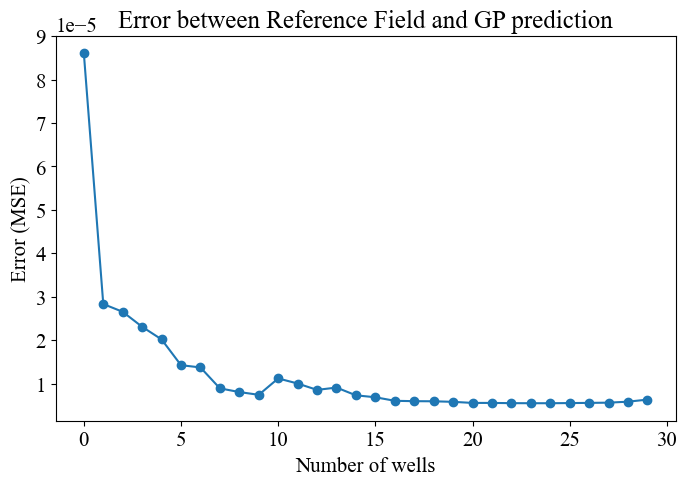

In [41]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(pd.Series(errors[0:31]), marker='o')
plt.title('Error between Reference Field and GP prediction')
plt.xlabel('Number of wells')
plt.ylabel('Error (MSE)')

In [42]:
# Interpolate using selected wells 
ft=['Easting', 'Northing', 'Elevation', 'Slope']
pred_map, r_map, residuals, lr_trend = pylenm_df.interpolate_topo(X.iloc[selected_wells_idx], y[selected_wells_idx], XX, ft=ft, regression='lasso', smooth=True)

In [43]:
import matplotlib.patheffects as path_effects

def plotres_hor(pred_map, selected, nu_wells):
    fontsize = 15
    plt.rcParams["legend.loc"] = 'upper right'
    fig, ax = plt.subplots(1,2, figsize=(12,5), dpi=200)
    xx = np.array(XX)
    titles = [str("Water table Reference Field | {}".format("Averaged 2005")), str('GP Prediction | {} | Wells: {}'.format("Averaged 2005", nu_wells))]
    map_1 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                    xx[:,1].reshape(x_loc.shape),
                    pred_map.reshape(x_loc.shape),
                    cmap='plasma',
                    vmin=y_map.min(), vmax=y_map.max())
    ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.2)
    ax[0].scatter(X.iloc[selected[0:5],0], X.iloc[selected[0:5],1], c='red', alpha=1, label='Initial wells [1-5]')
    ax[0].scatter(X.iloc[selected[5:13],0], X.iloc[selected[5:13],1], c='limegreen', alpha=1, label='Selected wells [6-13]')
    ax[0].scatter(X.iloc[selected[13:22],0], X.iloc[selected[13:22],1], c='yellow', alpha=1, label='Selected wells [14-22]')
    ax[0].scatter(X.iloc[selected[22:30],0], X.iloc[selected[22:30],1], c='blue', alpha=1, label='Selected wells [23-30]')
    ax[0].legend(bbox_to_anchor=(1.05, 1.45))
    fig.colorbar(map_1, ax=ax[0]).set_label(label="Log{} Groundwater table elevation (m)".format('$_{2}$'), size=fontsize)
    for i in range(2):
        ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
        ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
        plt.rc('font', size=fontsize)
        ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
        ax[i].locator_params(axis='both', nbins=4, tight=True)
    ax[0].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
    ax[1].ticklabel_format(style='sci', axis='y',scilimits=(-1,1), useMathText=True)
    ax[1].set_xlim([-1, 31])
    ax[1].set_ylim([0, 9e-05])

    for i in range(nu_wells):
        if(i<=4): c='r'
        elif(i>4 and i<=12): c='limegreen'
        elif(i>12 and i<=21): c='yellow'
        else: c='b'
        if(i!=nu_wells-1):
            ax[1].plot(range(1,31)[i:i+2],pd.Series(errors[0:31])[i:i+2], color=c, zorder=1)#,path_effects=[path_effects.SimpleLineShadow(),path_effects.Normal()])
        ax[1].scatter(range(1,31)[i],pd.Series(errors[0:31])[i], marker='o', color=c, zorder=2,path_effects=[path_effects.SimplePatchShadow(offset=(1, -2.5)),path_effects.Normal()])
    ax[1].axhspan(0,10,facecolor='gray', alpha=0.3)
    ax[1].grid(True, alpha=0.4)
    ax[1].set_xlabel('Number of wells')
    ax[1].set_ylabel('Error (MSE)')
    fig.show()

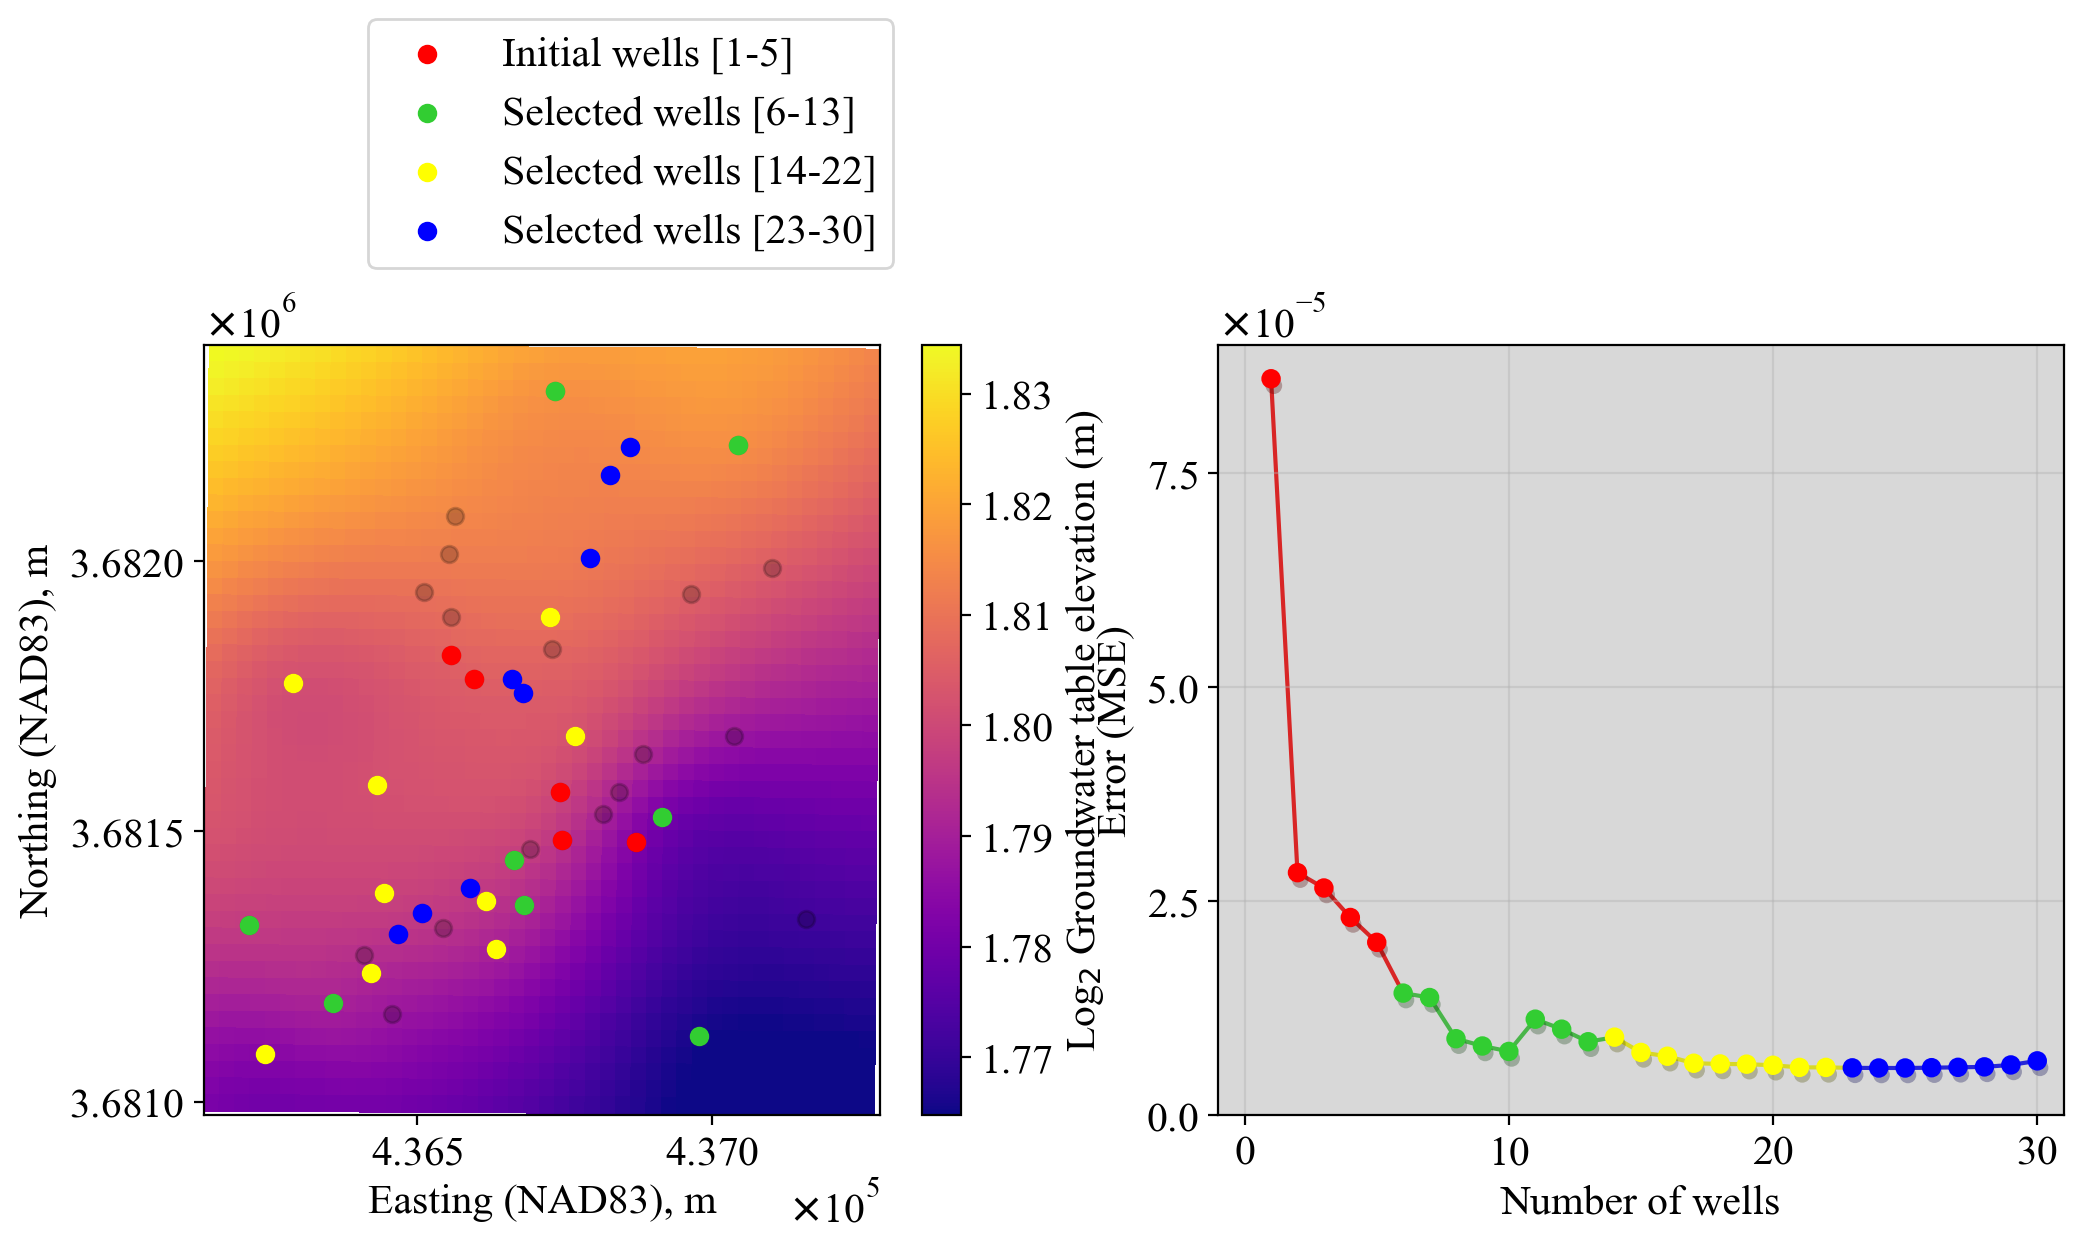

In [44]:
selected = selected_wells_idx[0:30]
nu_wells = len(selected)
pred_map, r_map, residuals, lr_trend = pylenm_df.interpolate_topo(X.iloc[selected], y[selected], XX, ft=ft, regression='lasso', smooth=True)
plotres_hor(pred_map, selected, nu_wells)